# CASA0009: Group Assignment (Part 3)

__Topic: An Investigation into the Biodiversity of England__

This set of codes is for the analysis of Part 3: Biodiversity hotspots in London.


In [1]:
# install kneed to find knee in KNN plot
!pip install kneed

In [2]:
# Load libraries

import pandas as pd
import geopandas as gpd
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, OPTICS
from kneed import KneeLocator

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


In [3]:
# Create function to compute number of occurrences, species richness and species evenness (ref: https://sciencing.com/calculate-species-evenness-2851.html)
def cal_indicators(df):
    
    # Compute number of occurrences
    occ = len(df)
    
    # Compute  species richness
    sp_richness = len(df.speciesKey.unique().tolist())
    
    # Create frequency table of species
    df_out = df.groupby('speciesKey').count().reset_index()[['speciesKey', 'gbifID']].rename({'gbifID': 'Count'}, axis = 1)

    # Compute proportion of all species
    df_out['Proportion'] = df_out['Count'] / occ

    # Compute natural log of proportion
    df_out['ln_P'] = df_out['Proportion'].apply(math.log)

    # Compute P x In P
    df_out['P_ln_P'] = df_out['Proportion'] * df_out['ln_P']

    # Compute Shannon diversity index
    H = -sum(df_out['P_ln_P'])

    # Compute species evenness
    if sp_richness == 1:
        sp_evenness = 0
    else:
        sp_evenness = H / math.log(sp_richness)
    
    return occ, sp_richness, sp_evenness

## Load Data

### Occurrence data

In [4]:
# Import data - occurrence data downloaded from GBIF with the following search parameters:
# Administrative areas (gadm.org): GBR.1.36_1 (i.e. London)
# Year: Between start of 2011 and end of 2021

col_name = ['gbifID', 
            'decimalLatitude', 
            'decimalLongitude',
            'month', 
            'year', 
            'speciesKey', 
            'issue']

ldn_pdf = pd.read_csv(os.path.join("Data", "London_2011_21.csv"), sep='\t', low_memory=False, usecols=col_name)

In [5]:
# Convert to geopanda dataframe
ldn_gdf = gpd.GeoDataFrame(ldn_pdf, 
                           geometry=gpd.points_from_xy(ldn_pdf['decimalLongitude'], ldn_pdf['decimalLatitude'], 
                                                       crs='epsg:4326'))

In [6]:
# Extract occurrences in 2021
ldn_2021 = ldn_gdf[ldn_gdf['year'] == 2021]

In [7]:
# Re-project to BNG
ldn_2021 = ldn_2021.to_crs("epsg:27700")

### London map

In [8]:
# Get London map
boros = gpd.read_file('Data/London_Boroughs.gpkg')
boros = boros.to_crs('epsg:27700')

ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn = ldn.set_geometry('original')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [9]:
# Spatial join - ensuring that all occurrences are within London
ldn_2021 = gpd.sjoin(ldn_2021, ldn, op='intersects')
ldn_2021_cleaned = ldn_2021.drop(ldn_2021[(~ldn_2021.issue.isna()) & (ldn_2021.issue.str.contains('COORDINATE_ROUNDED'))].index)

## First Pass: OPTICS

### Prep data

In [10]:
# Get x, y-coords
ldn_2021_cleaned['x'] = ldn_2021_cleaned.geometry.x
ldn_2021_cleaned['y'] = ldn_2021_cleaned.geometry.y

In [11]:
# Prep dataset for DBSCAN clustering
cdf = ldn_2021_cleaned[['x','y']]

### Set parameters - minPts and epsilon

In [12]:
# Set min number of points for a cluster - arbitrarily choose 1% of all occurrences
minPts = round(0.01*len(cdf))

In [13]:
# Nearest Neighbour. 
# Note that as we are using BNG, we can use Euclidean dist (instead of haversine method),
# and all distances are in metres.

nbrs = NearestNeighbors(n_neighbors=minPts).fit(cdf)
distances, indices = nbrs.kneighbors(cdf)


In [14]:
distances = np.sort(distances[:,minPts-1], axis=0)

3015.5440681806886


<Figure size 360x360 with 0 Axes>

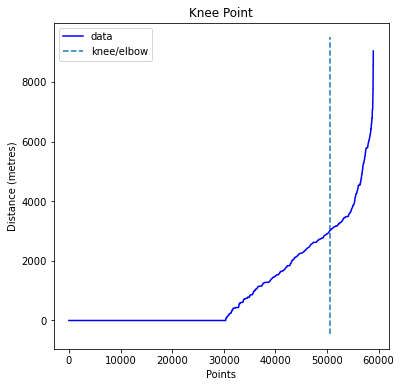

In [15]:
# Reference: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance (metres)")

epsilon = distances[knee.knee]
print(epsilon)

### Run OPTICS

In [16]:
opt = OPTICS(min_samples=minPts, max_eps=epsilon, metric = 'euclidean', n_jobs=-1)
opt.fit(cdf)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(max_eps=3015.5440681806886, metric='euclidean', min_samples=590,
       n_jobs=-1)

In [17]:
# Attach membership back to dataframe
ldn_2021_cleaned['hotspot'] = opt.labels_

### Draw convex hull around hotspots

In [18]:
# Create empty geodataframe
chull = gpd.GeoDataFrame(columns=['hotspot', 'convex_hull'])

for i in range(0, max(ldn_2021_cleaned['hotspot'])+1):
    
    # retrieve occurrences in cluster
    convex_pt = ldn_2021_cleaned[ldn_2021_cleaned['hotspot'] == i]
    # create convex hull
    #hull = gpd.GeoSeries(data = convex_pt.unary_union.convex_hull, crs='epsg:27700')
    # add row to chull
    hull = gpd.GeoDataFrame(gpd.GeoSeries(data = convex_pt.unary_union.convex_hull, crs='epsg:27700')).rename(columns={0:chull.columns[1]})
    hull[chull.columns[0]] = i
    chull = chull.append(hull)
        
chull.reset_index().drop(columns='index', inplace = True)

chull = chull.set_geometry('convex_hull', crs='epsg:27700')

chull.reset_index(drop=True, inplace=True)
hotspot_drop = chull[chull.geom_type != 'Polygon'].index
chull.drop(hotspot_drop, axis=0, inplace=True)
chull.reset_index(drop=True, inplace=True)

hotspot_noise = list(hotspot_drop)+[-1]
hotspot_original = hotspot_noise + list(chull['hotspot'])
hotspot_new = ([-1]*len(hotspot_noise)) + list(chull.index+1)
mapping = dict(zip(hotspot_original, hotspot_new))
chull['hotspot'] = chull['hotspot'].map(mapping)
ldn_2021_cleaned['hotspot'] = ldn_2021_cleaned['hotspot'].map(mapping)

## Second Pass: KMeans Clustering

### Compute indicators for hotspots in each year

In [19]:
# Spatial join to find occurrences within the hotspots
ldn_hotspot = gpd.sjoin(ldn_2021.drop(columns='index_right'), chull, op='intersects')
ldn_hotspot.drop(columns='index_right', inplace=True)

In [20]:
# Create lists for parameters - hotspots
hotspots = list(chull.hotspot)
indicators = ['occ', 'sp_richness', 'sp_evenness']

In [21]:
# Create lists to hold outputs in long format
hotspot = []
indicator = []
value = []

In [22]:
# Compute area of each hotspot
hotspot_area = chull.area

In [23]:
# Compute indicators in long format

# for each hotspot
for hotspot_idx in hotspots:
    # segment out data
    df_hotspot = ldn_hotspot[ldn_hotspot['hotspot'] == hotspot_idx]
    # compute indicators
    if len(df_hotspot) == 0:
        globals()[indicators[0]] = 0
        globals()[indicators[1]] = 0
        globals()[indicators[2]] = 0
    else:
        globals()[indicators[0]], globals()[indicators[1]], globals()[indicators[2]] = cal_indicators(df_hotspot)
    # convert occurrence and species richness data to density
    occ = occ/hotspot_area[hotspot_idx-1]
    sp_richness = sp_richness/hotspot_area[hotspot_idx-1]
        
    # for each indicator:
    for indicator_idx in indicators:
        # append results to respective list
        hotspot.append(hotspot_idx)
        indicator.append(indicator_idx)
        value.append(globals()[indicator_idx])
            

In [24]:
# Create dataframe
hotspot_ind = pd.DataFrame(list(zip(hotspot, indicator, value)), 
                           columns=['hotspot', 'indicator', 'value'])

### Normalization

In [25]:
# Pivot wide
hotspot_ind_wide = hotspot_ind.pivot(index='hotspot',columns=['indicator'], values='value')
hotspot_ind_wide.reset_index(inplace=True)

In [26]:
# Create copy and keep only species richness and evenness
df_norm = hotspot_ind_wide.copy()
df_norm = df_norm[indicators[1:3]]

In [27]:
# Normalization
scaler = MinMaxScaler()
for c in df_norm.columns:
    df_norm[c] = scaler.fit_transform(df_norm[c].values.reshape(-1,1))

### Optimization of clustering

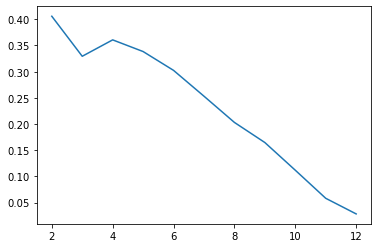

In [28]:
# Find optimal number of clusters

results = {'n':[], 'ss':[]}

for num_clusters in range(2,len(df_norm)):
    
    # Do KMeans clustering
    kmeans_output = KMeans(n_clusters=num_clusters, n_init=10).fit(df_norm)
    
    # Calculate silhouette score
    clustering_ids_kmeans = kmeans_output.labels_
    silhouette_kmeans = silhouette_score(df_norm, clustering_ids_kmeans)
    
    results['n'].append(num_clusters)
    results['ss'].append(silhouette_kmeans)

plt.plot(results['n'], results['ss'])

In [29]:
# Optimal number clusters
opt_cluster=results['n'][np.argmax(results['ss'])]

### KMeans clustering

In [30]:
# Run clustering with optimal number of clusters
kmeans_method = KMeans(n_clusters=opt_cluster, n_init=100).fit(df_norm)

In [31]:
# Cluster mapping
mapping = dict(zip(hotspots,list(kmeans_method.labels_+1)))

In [32]:
# Map k_cluster back to hotspot_ind (long format) and chull
hotspot_ind.insert(loc=1, column='k_cluster', value=hotspot_ind['hotspot'].map(mapping))
chull.insert(loc=1, column='k_cluster', value=chull['hotspot'].map(mapping))

### Making sense of data

In [33]:
hotspot_ind_wide.insert(loc=1, column='k_cluster', value=hotspot_ind_wide['hotspot'].map(mapping))

<AxesSubplot:xlabel='sp_richness', ylabel='sp_evenness'>

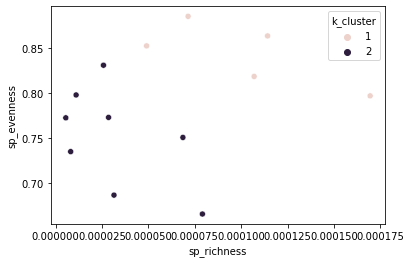

In [34]:
sns.scatterplot(data=hotspot_ind_wide, x='sp_richness', y='sp_evenness', hue='k_cluster')

<AxesSubplot:>

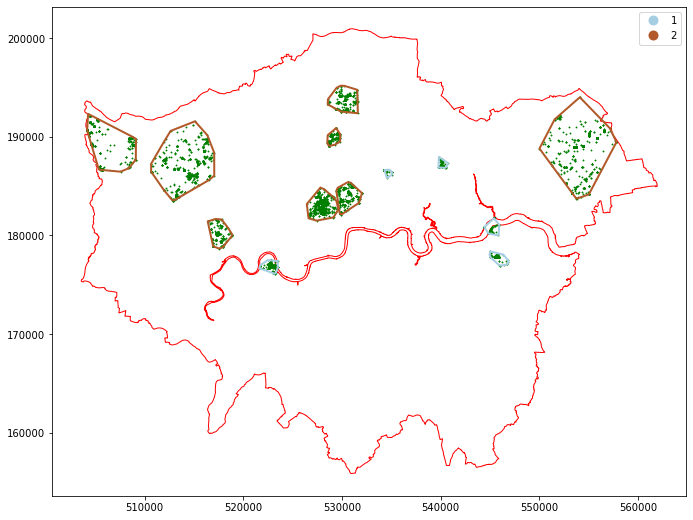

In [35]:
# Plot now
fig, ax = plt.subplots(1,1, figsize=(12,9))
ldn.plot(edgecolor='red', facecolor='none', ax=ax)
ldn_hotspot.plot(marker='*', color='green', markersize=1.0, ax=ax);
chull.plot(column='k_cluster', facecolor='none', linewidth = 2.0, 
           categorical = True, cmap = 'Paired', legend=True,ax=ax)

## Key Takeaways:
- Using OPTICS, 13 biodiversity hotspots were identified in London.
- Using KMeans clustering, the hotspots were divided into two clusters. 5 hotspots were in cluster 1, which has high species richness and species evennness; while the remaining 8 hotspots were in cluster 2, which has lower species richness and species evennness. Hence, the 5 hotspots could be prioritized for biodiversity conservation efforts.

In [36]:
# Switch CRS to WGS84 because that is what plotly uses
chull = chull.to_crs("epsg:4326")

In [37]:
# Pivot indicators wide
hotspot_ind_wide = hotspot_ind.pivot(index=['hotspot'],columns=['indicator'], values='value').reset_index()
hotspot_ind_wide.insert(loc=1, column='k_cluster', value=hotspot_ind_wide['hotspot'].map(mapping))

In [38]:
# Merge indicator value to geometry then re-order columns
hotspots_merge = chull.merge(hotspot_ind_wide[['hotspot','occ','sp_evenness','sp_richness']],
                                on = 'hotspot')
hotspots_merge = hotspots_merge[['hotspot','k_cluster','occ', 'sp_richness', 'sp_evenness','convex_hull']]

In [39]:
# Convert CRS to BNG
hotspots_merge=hotspots_merge.to_crs('epsg:27700')

In [40]:
# Find centroid
hotspots_centroid=hotspots_merge.centroid

In [41]:
# Convert CRS back to WGS
hotspots_centroid=hotspots_centroid.to_crs('epsg:4326')
hotspots_merge=hotspots_merge.to_crs('epsg:4326')

In [42]:
# Insert x and y coordinates of centroid
hotspots_merge.insert(loc=5, column='centroid_x',value=hotspots_centroid.geometry.x)
hotspots_merge.insert(loc=6, column='centroid_y',value=hotspots_centroid.geometry.y)

In [43]:
hotspots_merge=hotspots_merge.sort_values(['k_cluster','centroid_x']).reset_index().drop(columns='index')
mapper=dict(zip(hotspots_merge.hotspot,list(range(1,len(hotspots_merge)+1))))
hotspots_merge['hotspot']=hotspots_merge['hotspot'].map(mapper)

In [44]:
# Add in zoom level
hotspots_merge.insert(loc=7, column='zoom_level',
                      value=[10, 10, 10.8, 10.8, 11.5, 11, 11, 9.7, 11.5, 12, 12, 11.8, 11.5])

In [45]:
ldn_hotspot['hotspot']=ldn_hotspot['hotspot'].map(mapper)

In [46]:
ldn_hotspot.drop(columns=['issue'], inplace=True)